Device: cuda
Generated 28500 collocation points and 1500 initial condition points
Starting training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate



Epoch    0 | Loss: 7.15e-01, PDE: 3.09e-01, IC: 4.07e-02, LR: 1.02e-04
Epoch  100 | Loss: 8.15e-04, PDE: 8.05e-04, IC: 1.04e-06, LR: 2.52e-04
Epoch  200 | Loss: 2.41e-04, PDE: 2.29e-04, IC: 1.23e-06, LR: 4.02e-04
Epoch  300 | Loss: 1.21e-04, PDE: 9.32e-05, IC: 2.74e-06, LR: 5.52e-04
Epoch  400 | Loss: 3.44e-04, PDE: 7.04e-05, IC: 2.74e-05, LR: 7.02e-04
Stopped early at epoch 401 because the loss did not improve for 15 checks.
Training ended in 121.69 s


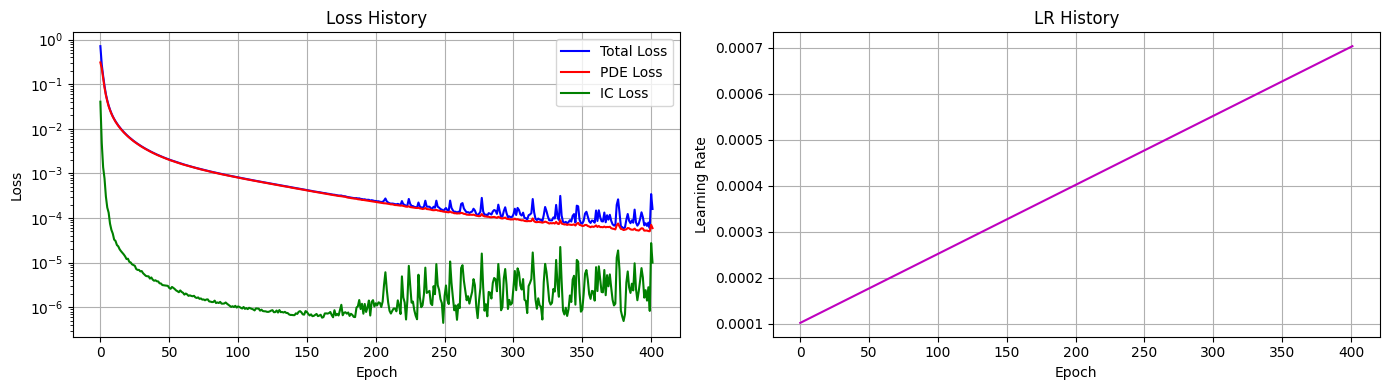


Evaluation:
MSE (Real): 9.009231e-02, MSE (Imag): 9.521279e-02
L2 Rel (Real): 1.342375e+00, L2 Rel (Imag): 1.391544e+00


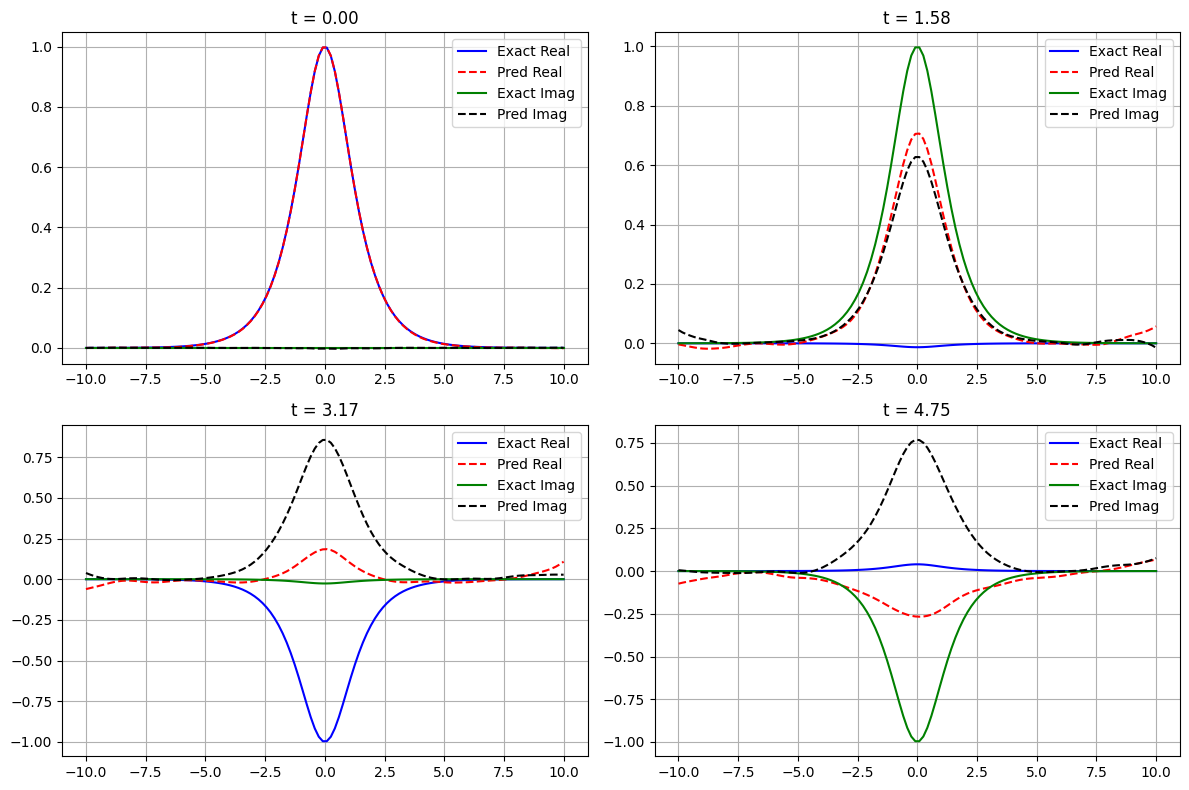

Model saved.


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import interact, FloatSlider
import time
from torch.amp import autocast, GradScaler
from tqdm.notebook import tqdm

# Seeds
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.benchmark = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

def exact_solution(x, t):
    u = 1/np.cosh(x) * np.cos(t)
    v = 1/np.cosh(x) * np.sin(t)
    return u, v

class FourierFeatureLayer(nn.Module):
    def __init__(self, in_dim, mapping_size=256, scale=5):
        super().__init__()
        self.register_buffer('B', torch.randn(in_dim, mapping_size // 2) * scale)
    def forward(self, x):
        x_proj = x @ self.B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class EnhancedPINN(nn.Module):
    def __init__(self, hidden_dim=128, fourier_features=256, fourier_scale=5):
        super().__init__()
        self.fourier = FourierFeatureLayer(2, fourier_features, fourier_scale)
        self.net = nn.Sequential(
            nn.Linear(fourier_features, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, 2)
        )
        self._init_weights()
        self.register_buffer('x_mean', torch.zeros(1))
        self.register_buffer('x_std', torch.ones(1))
        self.register_buffer('t_mean', torch.zeros(1))
        self.register_buffer('t_std', torch.ones(1))

    def _init_weights(self):
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, gain=1.0)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def set_normalization(self, x_data, t_data):
        self.x_mean = torch.mean(x_data)
        self.x_std = torch.std(x_data) + 1e-8
        self.t_mean = torch.mean(t_data)
        self.t_std = torch.std(t_data) + 1e-8

    def forward(self, x, t):
        x_norm = (x - self.x_mean) / self.x_std
        t_norm = (t - self.t_mean) / self.t_std
        inputs = torch.cat([x_norm, t_norm], dim=1)
        features = self.fourier(inputs)
        return self.net(features)

def compute_pde_residual(model, X):
    X = X.clone().detach().requires_grad_(True)
    x = X[:, :1]
    t = X[:, 1:2]
    out = model(x, t)
    u = out[:, :1]
    v = out[:, 1:2]
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    v_t = torch.autograd.grad(v, t, torch.ones_like(v), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    v_x = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x, x, torch.ones_like(v_x), create_graph=True)[0]
    R1 = -v_t + 0.5*u_xx + (u**2 + v**2)*u
    R2 =  u_t + 0.5*v_xx + (u**2 + v**2)*v
    return R1, R2

def generate_adaptive_collocation_points(x_range, t_range, n_colloc=20000, ratio_boundary=0.2):
    x_min, x_max = x_range
    t_min, t_max = t_range
    n_interior = int(n_colloc * (1 - ratio_boundary))
    n_boundary = n_colloc - n_interior
    n_ic = max(500, n_boundary // 2)
    beta = 2.0
    x_center = (np.random.beta(beta, beta, n_interior)*2 -1)*(x_max/2)
    x_uniform = np.random.uniform(x_min, x_max, n_interior)
    mask = np.random.rand(n_interior) < 0.7
    x_interior = np.where(mask, x_center, x_uniform)
    t_interior = np.random.uniform(t_min, t_max, n_interior)
    x_ic = np.linspace(x_min, x_max, n_ic)
    t_ic = np.zeros_like(x_ic)
    u_ic = 1/np.cosh(x_ic)
    v_ic = np.zeros_like(u_ic)
    x_boundary = np.concatenate([np.ones(n_boundary//4)*x_min,
                                 np.ones(n_boundary//4)*x_max])
    t_boundary = np.random.uniform(t_min, t_max, n_boundary//2)
    x_colloc = np.concatenate([x_interior, x_boundary])
    t_colloc = np.concatenate([t_interior, t_boundary])
    X_colloc = np.stack([x_colloc, t_colloc], axis=1)
    X_ic = np.stack([x_ic, t_ic], axis=1)
    uv_ic = np.stack([u_ic, v_ic], axis=1)
    print(f"Generated {X_colloc.shape[0]} collocation points and {X_ic.shape[0]} initial condition points")
    return X_colloc, X_ic, uv_ic

def train_pinn(model, X_colloc, X_ic, uv_ic,
               epochs=2000, batch_size=4096,
               pde_weight=1.0, ic_weight=10.0,
               lr=1e-3, weight_decay=1e-6,
               patience=15):
    print("Starting training...")
    start = time.time()

    X_colloc = torch.tensor(X_colloc, dtype=torch.float32).to(device)
    X_ic = torch.tensor(X_ic, dtype=torch.float32).to(device)
    uv_ic = torch.tensor(uv_ic, dtype=torch.float32).to(device)

    x_all = torch.cat([X_colloc[:, 0:1], X_ic[:, 0:1]])
    t_all = torch.cat([X_colloc[:, 1:2], X_ic[:, 1:2]])
    model.set_normalization(x_all, t_all)

    use_amp = torch.cuda.is_available()
    scaler = GradScaler('cuda') if use_amp else None

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    mse_loss = nn.MSELoss()

    n_samples = X_colloc.shape[0]
    n_batches = n_samples // batch_size + (1 if n_samples % batch_size else 0)

    # OneCycleLR
    total_steps = epochs*n_batches
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=lr,
        total_steps=total_steps,
        div_factor=10.0,
        final_div_factor=100.0,
        anneal_strategy='linear'
    )

    best_loss = float('inf')
    best_state = None
    patience_counter = 0

    loss_hist = []
    pde_hist = []
    ic_hist = []
    lr_hist = []

    for epoch in range(epochs):
        epoch_loss = 0.0
        epoch_pde = 0.0
        epoch_ic = 0.0

        indices = torch.randperm(n_samples, device=device)
        for i in range(n_batches):
            start_idx = i*batch_size
            end_idx = min(start_idx + batch_size, n_samples)
            batch_idx = indices[start_idx:end_idx]
            X_batch = X_colloc[batch_idx]

            optimizer.zero_grad()
            if use_amp:
                with autocast('cuda'):
                    R1, R2 = compute_pde_residual(model, X_batch)
                    loss_pde = mse_loss(R1, torch.zeros_like(R1)) + mse_loss(R2, torch.zeros_like(R2))
                    pred_ic = model(X_ic[:, :1], X_ic[:, 1:2])
                    loss_ic = mse_loss(pred_ic, uv_ic)
                    loss = pde_weight*loss_pde + ic_weight*loss_ic
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                R1, R2 = compute_pde_residual(model, X_batch)
                loss_pde = mse_loss(R1, torch.zeros_like(R1)) + mse_loss(R2, torch.zeros_like(R2))
                pred_ic = model(X_ic[:, :1], X_ic[:, 1:2])
                loss_ic = mse_loss(pred_ic, uv_ic)
                loss = pde_weight*loss_pde + ic_weight*loss_ic
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

            batch_weight = (end_idx - start_idx)/n_samples
            epoch_loss += loss.item()*batch_weight
            epoch_pde += loss_pde.item()*batch_weight
            epoch_ic += loss_ic.item()*batch_weight
            scheduler.step()

        loss_hist.append(epoch_loss)
        pde_hist.append(epoch_pde)
        ic_hist.append(epoch_ic)
        lr_hist.append(optimizer.param_groups[0]['lr'])

        if epoch % 100 == 0:
            print(f"Epoch {epoch:4d} | Loss: {epoch_loss:.2e}, PDE: {epoch_pde:.2e}, IC: {epoch_ic:.2e}, LR: {optimizer.param_groups[0]['lr']:.2e}")

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience and epoch > epochs//5:
            print(f"Stopped early at epoch {epoch} because the loss did not improve for {patience} checks.")
            break

    # Load best
    if best_state is not None:
        model.load_state_dict(best_state)

    elapsed = time.time() - start
    print(f"Training ended in {elapsed:.2f} s")

    # Plot
    plt.figure(figsize=(14,4))
    plt.subplot(1,2,1)
    plt.semilogy(loss_hist, 'b-', label='Total Loss')
    plt.semilogy(pde_hist, 'r-', label='PDE Loss')
    plt.semilogy(ic_hist, 'g-', label='IC Loss')
    plt.legend()
    plt.grid(True)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss History')

    plt.subplot(1,2,2)
    plt.plot(lr_hist, 'm-')
    plt.grid(True)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('LR History')
    plt.tight_layout()
    plt.show()

def evaluate_and_visualize(model, x_range, t_range, resolution=100):
    x = np.linspace(*x_range, resolution)
    t = np.linspace(*t_range, resolution)
    X, T = np.meshgrid(x, t)
    U_exact, V_exact = exact_solution(X, T)
    X_flat = torch.tensor(X.flatten()[:, None], dtype=torch.float32).to(device)
    T_flat = torch.tensor(T.flatten()[:, None], dtype=torch.float32).to(device)

    model.eval()
    batch_size = 10000
    n_samples = X_flat.shape[0]
    n_batches = (n_samples + batch_size -1)//batch_size
    U_pred_list, V_pred_list = [], []

    with torch.no_grad():
        for i in range(n_batches):
            start_idx = i*batch_size
            end_idx = min(start_idx+batch_size, n_samples)
            out = model(X_flat[start_idx:end_idx], T_flat[start_idx:end_idx])
            U_pred_list.append(out[:,0].cpu().numpy())
            V_pred_list.append(out[:,1].cpu().numpy())
    U_pred = np.concatenate(U_pred_list).reshape(X.shape)
    V_pred = np.concatenate(V_pred_list).reshape(X.shape)

    Error_u = np.abs(U_exact - U_pred)
    Error_v = np.abs(V_exact - V_pred)
    mse_u = np.mean(Error_u**2)
    mse_v = np.mean(Error_v**2)
    l2_u = np.sqrt(np.sum(Error_u**2))/np.sqrt(np.sum(U_exact**2))
    l2_v = np.sqrt(np.sum(Error_v**2))/np.sqrt(np.sum(V_exact**2))

    print("\nEvaluation:")
    print(f"MSE (Real): {mse_u:.6e}, MSE (Imag): {mse_v:.6e}")
    print(f"L2 Rel (Real): {l2_u:.6e}, L2 Rel (Imag): {l2_v:.6e}")

    # 2D slices
    times = [0, np.pi/2, np.pi, 3*np.pi/2]
    plt.figure(figsize=(12,8))
    for i, tv in enumerate(times):
        idx = np.abs(t - tv).argmin()
        plt.subplot(2,2,i+1)
        plt.plot(x, U_exact[idx], 'b-', label='Exact Real')
        plt.plot(x, U_pred[idx], 'r--', label='Pred Real')
        plt.plot(x, V_exact[idx], 'g-', label='Exact Imag')
        plt.plot(x, V_pred[idx], 'k--', label='Pred Imag')
        plt.title(f"t = {t[idx]:.2f}")
        plt.grid(True)
        plt.legend()
    plt.tight_layout()
    plt.show()

def main():
    x_range = (-10,10)
    t_range = (0, 5*np.pi)
    X_colloc, X_ic, uv_ic = generate_adaptive_collocation_points(x_range, t_range, n_colloc=30000, ratio_boundary=0.1)

    model = EnhancedPINN(hidden_dim=128, fourier_features=256, fourier_scale=5).to(device)
    train_pinn(model, X_colloc, X_ic, uv_ic,
               epochs=2000,
               batch_size=2048,
               pde_weight=1.0,
               ic_weight=10.0,
               lr=1e-3,
               weight_decay=1e-6,
               patience=15)
    evaluate_and_visualize(model, x_range, t_range, resolution=120)
    torch.save(model.state_dict(), 'schrodinger_improved.pth')
    print("Model saved.")

if __name__=="__main__":
    main()
